# Processing and stacking astrophotography images

As a first step we will process a single image using common image processing operations. After that the same operations will be ran on a multitude of images to show the impact on noise. Finally the results will be aggregated in an mp4 image. 

## Import image


In [32]:
import cv2
import numpy as np

# Specify the path to the image
image_path = r"E:\Astronomie\Images\Nebulas\Orion Nebula\Orion 11 feb 2020\Image data\JPEG\IMG_6407.JPG"

def read_image(path): 
    # Load the image
    image = cv2.imread(path)

    # Check if the image was loaded
    if image is not None:
        print("Image imported")
    else:
        raise FileNotFoundError("Image not found or failed to load.")
    return image

# Load the image
image = read_image(image_path)

Image imported


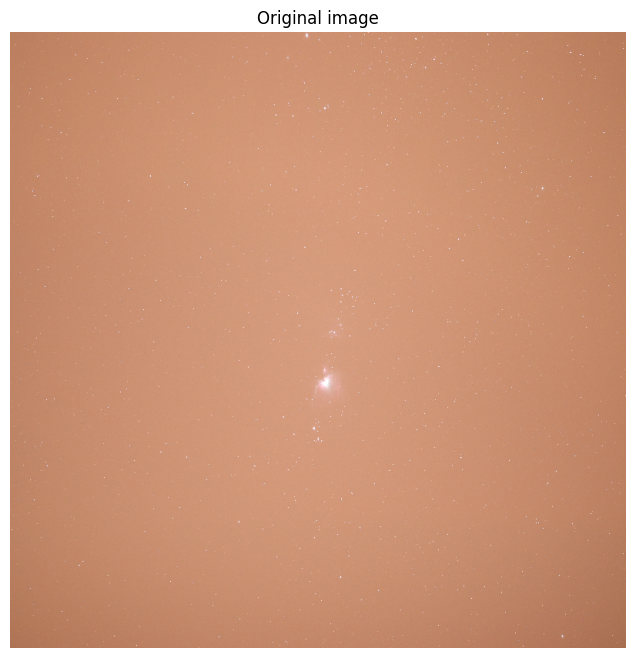

In [33]:
import matplotlib.pyplot as plt
def display_image(image, dimensions = (800,800), title=""):
    resized_image = cv2.resize(image, dimensions)
    
    # Convert BGR to RGB for correct color display in matplotlib
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the resized image using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(resized_image_rgb)
    plt.title(title)
    plt.axis('off')  # Hide the axes for a cleaner display
    plt.show()

display_image(image, (800,800), "Original image")

## Cropping

In [34]:
def crop(image, center, dimensions): 
    center_x, center_y = center
    width, height = dimensions
    
    x_start = center_x - width // 2
    y_start = center_y - height // 2
    x_end = center_x + width // 2
    y_end = center_y + height // 2
    return image[y_start:y_end, x_start:x_end]; 

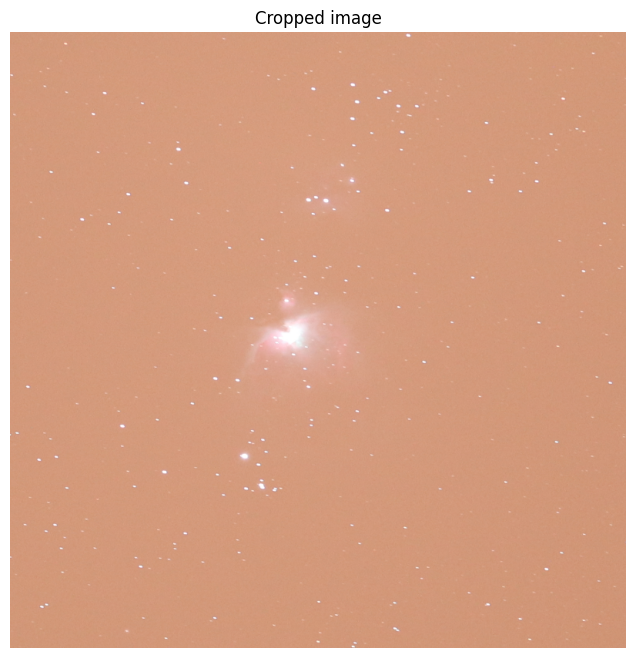

In [35]:

# Center of the crop area
center = (3140, 2290)

# Width and height of the crop area
dimensions = (1500, 1500)

# Calculate cropping boundaries using the center point
cropped_image = crop(image, center, dimensions)
# Resize the image to 800x600

display_image(cropped_image, (800,800), "Cropped image")

## Transform

In [36]:
import cv2
import numpy as np

def transform(channel, a, b,): 
    return np.clip(np.clip(channel + b, 0, 255) * a, 0, 255).astype(np.uint8)

def plot_channel_histograms(original_image, transformed_image):
    # Split original and transformed images into B, G, R channels
    original_channels = cv2.split(original_image)
    transformed_channels = cv2.split(transformed_image)
    
    # Calculate histograms for original channels
    original_counts = [cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten() for channel in original_channels]
    
    # Calculate histograms for transformed channels
    transformed_counts = [cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten() for channel in transformed_channels]

    # Pixel intensity values from 0 to 255
    x = np.arange(256)

    # Set up plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Colors and labels for channels
    colors = ['blue', 'green', 'red']
    labels = ["Blue", "Green", "Red"]

    # Plot original channels
    for i, color in enumerate(colors):
        axes[0].bar(x, original_counts[i], color=color, alpha=0.5, width=1.0, label=labels[i])
    axes[0].set_title("Channels - Before Transformation")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")
    axes[0].set_xlim(0, 255)
    axes[0].legend()

    # Plot transformed channels
    for i, color in enumerate(colors):
        axes[1].bar(x, transformed_counts[i], color=color, alpha=0.5, width=1.0, label=labels[i])
    axes[1].set_title("Channels - After Transformation")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")
    axes[1].set_xlim(0, 255)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


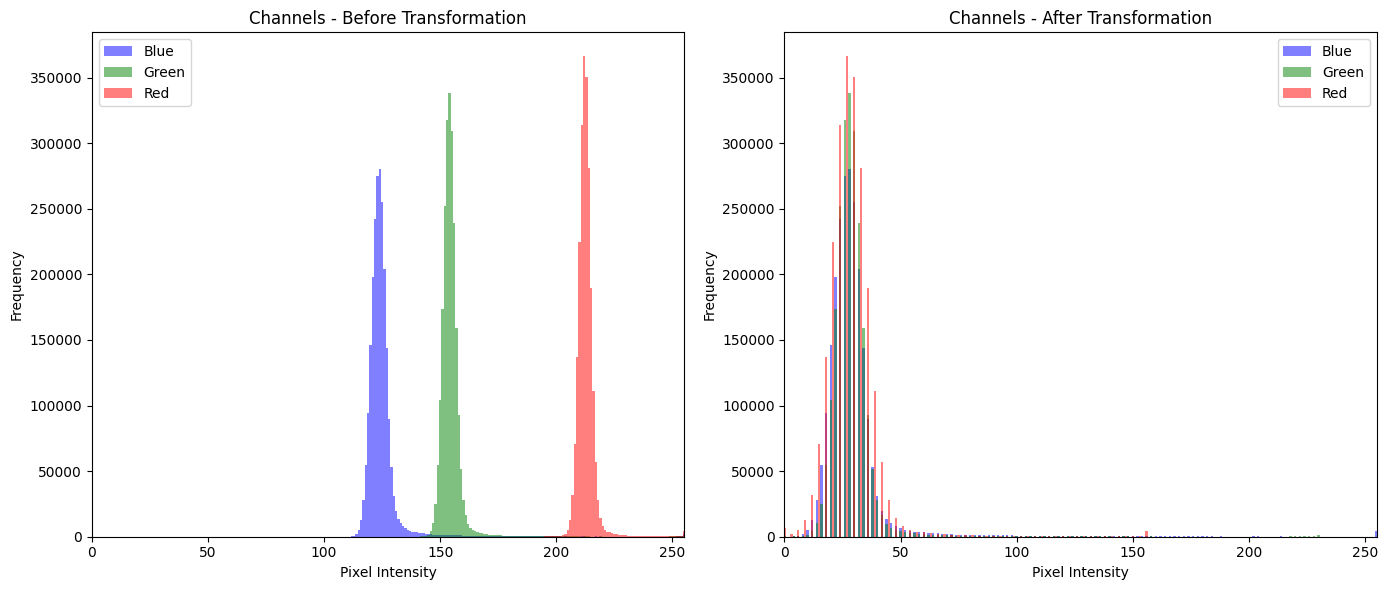

In [37]:
b_channel, g_channel, r_channel = cv2.split(cropped_image)

# Apply different scaling and offset to each channel
b_transformed = transform(b_channel, 2, -110) #2, -110 
g_transformed = transform(g_channel, 2, -140) #2, -140
r_transformed = transform(r_channel, 3, -203) #3 -200


# Merge the channels back into a single image
transformed_image = cv2.merge((b_transformed, g_transformed, r_transformed))
plot_channel_histograms(cropped_image, transformed_image)

## Display the result

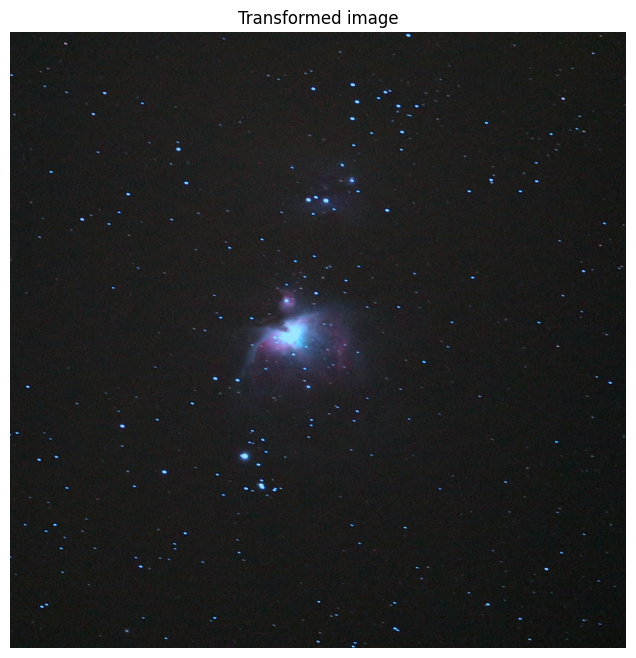

In [38]:

display_image(transformed_image, (800,800), "Transformed image")

# Stacking multiple images

## Processing a single image in one go

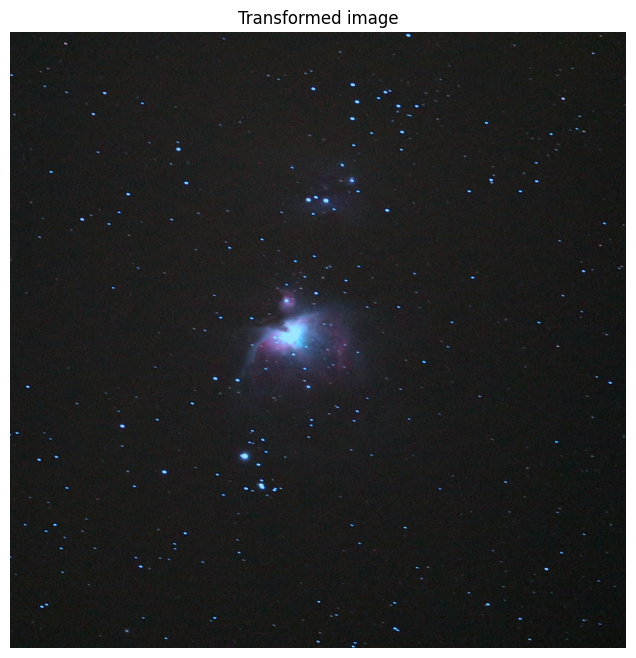

In [39]:
import cv2
import numpy as np

def color_enhance(image, b_params, g_params, r_params):
    b_channel, g_channel, r_channel = cv2.split(image)
    
    
    # Apply transformations to each channel
    b_transformed = transform(b_channel, *b_params)
    g_transformed = transform(g_channel, *g_params)
    r_transformed = transform(r_channel, *r_params)
    
    # Merge the channels back into a single image
    transformed_image = cv2.merge((b_transformed, g_transformed, r_transformed))
    
    return transformed_image

# Parameters
center = (3140, 2290)
dimensions = (1500, 1500)
b_params = [2, -110]
g_params = [2, -140]
r_params = [3, -203]

# Process the image
cropped_image = crop(image, center, dimensions)
processed_image = color_enhance(cropped_image, b_params, g_params, r_params)

display_image(processed_image, (800,800), "Transformed image")

In [40]:
def color_enhance_def(image):
    return color_enhance(image, b_params, g_params, r_params)


In [41]:
import pandas as pd

# Load the CSV file with semicolon as delimiter
df = pd.read_csv('stacking.csv', delimiter=';')

# Combine 'Path' and 'File' columns to create a full path to each image
df['FullPath'] = df['Path'] + '/' + df['File']

# Select only the necessary columns and make a copy
filtered_df = df[['FullPath', 'File', 'dX', 'dY', 'Angle']].copy()

# Remove the ° symbol, convert 'Angle' to float
filtered_df['Angle'] = filtered_df['Angle'].str.replace('°', '').astype(float)

# Display the modified DataFrame
filtered_df.head()


,FullPath,File,dX,dY,Angle
0,E:/Astronomie/Images/Nebulas/Orion Nebula/Orio...,IMG_6678.JPG,206.37,94.72,0.38
1,E:/Astronomie/Images/Nebulas/Orion Nebula/Orio...,IMG_6463.JPG,63.31,-91.22,0.11
2,E:/Astronomie/Images/Nebulas/Orion Nebula/Orio...,IMG_6640.JPG,174.04,57.78,0.34
3,E:/Astronomie/Images/Nebulas/Orion Nebula/Orio...,IMG_6680.JPG,199.37,94.08,0.38
4,E:/Astronomie/Images/Nebulas/Orion Nebula/Orio...,IMG_6686.JPG,212.46,101.74,0.41


## Aligning multiple images

In [71]:
def euclid_transform(image, dx, dy, angle):
    # Get the dimensions of the image
    (height, width) = image.shape[:2]

    # Determine the center of the image for rotation
    center_x = width // 2
    center_y = height // 2

    # Step 2: Translate the rotated image by (dx, dy)
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    translated_image = cv2.warpAffine(image, translation_matrix, (width, height))

    # Step 1: Rotate the image around its center
    rotation_matrix = cv2.getRotationMatrix2D((center_x -dx, center_y -dy), angle, 1.0)
    rotated_image = cv2.warpAffine(translated_image, rotation_matrix, (width, height))

    return rotated_image


In [72]:
def align_and_average_images(df):
    aligned_images = []
    
    for _, row in df.iterrows():
        # Read image from FullPath
        image = read_image(row['FullPath'])
        
        # Apply Euclidean transformation for alignment
        aligned_image = euclid_transform(image, dx= row['dX'], dy=row['dY'], angle=row['Angle'])
        
        # Append aligned image to list
        aligned_images.append(aligned_image)
    
    # Calculate average of aligned images
    average_image = np.mean(aligned_images, axis=0).astype(np.uint8)
    return average_image

In [73]:
image6678 = color_enhance_def(read_image(r"E:\Astronomie\Images\Nebulas\Orion Nebula\Orion 11 feb 2020\Image data\JPEG\IMG_6678.JPG"))
image6463 = color_enhance_def(read_image(r"E:\Astronomie\Images\Nebulas\Orion Nebula\Orion 11 feb 2020\Image data\JPEG\IMG_6463.JPG"))


Image imported
Image imported


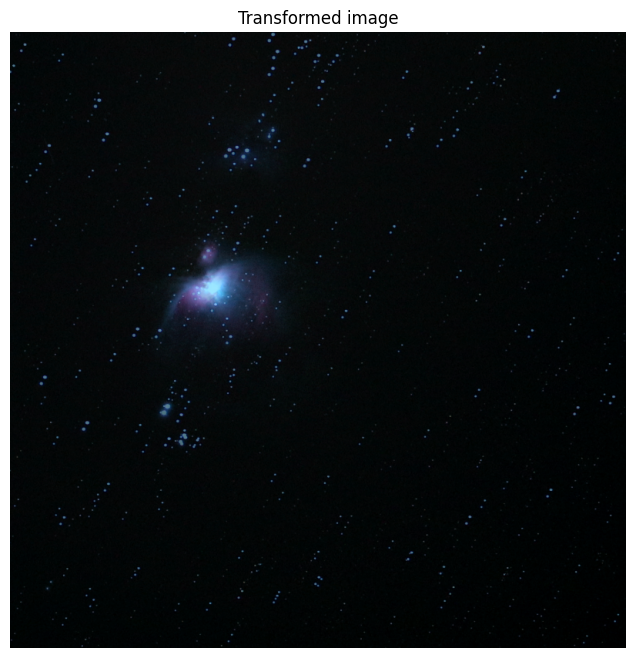

In [74]:

rotated_6463 = euclid_transform(image6463, -143.06, -185.94,0.27)
average_image = np.mean([rotated_6463, image6678], axis=0).astype(np.uint8)

display_image(crop(average_image, center, dimensions), (800,800), "Transformed image")


Image imported
Image imported


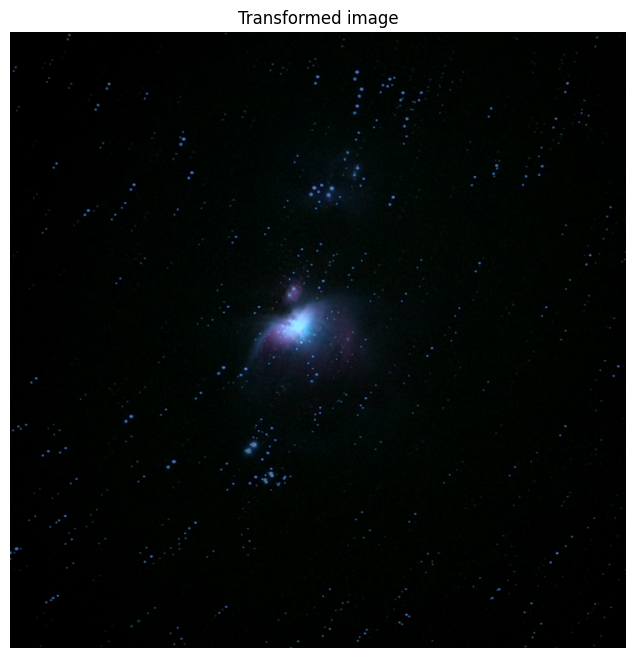

In [75]:
# Test with the first two images
average_image = align_and_average_images(filtered_df.iloc[:2])

# Continue with cropping and processing as before
cropped_image = crop(average_image, center, dimensions)
processed_image = color_enhance(cropped_image, b_params, g_params, r_params)

# Display the processed image
display_image(processed_image, (800, 800), "Transformed image")


https://www.cloudynights.com/topic/772997-deepskystacker-saving-aligned-images-individually/